# Kaggle Competition: Novozymes Enzyme Stability Prediction, Help identify the thermostable mutations in enzymes

by: Tianxiong Yu, upload at <b><a href="https://github.com/Lecter314/MLDM_2022_YuTianxiong_EEP/tree/main/Novozymes%20Enzyme%20Stability%20Prediction">github_MLDM_2022_YuTianxiong_EEP</a></b>

## 2 Import related libraries and datasets

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [42]:
data_old = pd.read_csv("train.csv")
data_update = pd.read_csv("train_updates_20220929.csv")

### 2.1 Dataset description
In this competition, you are asked to develop models that can predict the ranking of protein thermostability (as measured by melting point, tm) after single-point amino acid mutation and deletion.

For the training set, the protein thermostability (experimental melting temperature) data includes natural sequences, as well as engineered sequences with single or multiple mutations upon the natural sequences. The data are mainly from different sources of published studies such as Meltome atlas—thermal proteome stability across the tree of life. Many other public datasets exist for protein stability; please see the competition Rule 7C for external data usage requirements. There are also other publicly available methods which can predict protein stabilities such as ESM, EVE and Rosetta etc., without using the provided training set. These methods may also be used as part of the competition.


* Rule 7C (COMPETITION DATA, C. External Data) You may use data other than the Competition Data (“External Data”) to develop and test your Submissions. However, you will ensure the External Data is publicly available and equally accessible to use by all participants of the Competition for purposes of the competition at no cost to the other participants. The ability to use External Data under this Section 7.C (External Data) does not limit your other obligations under these Competition Rules, including but not limited to Section 11 (Winners Obligations).

The test set contains experimental melting temperature of over 2,413 single-mutation variant of an enzyme (GenBank: KOC15878.1), obtained by Novozymes A/S. The amino acid sequence of the **wild type** is:

<b>VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK</b> 

### 2.2 File description


* **train.csv** - the training data, with columns as follows:

    * seq_id: unique identifier of each protein variants
    * protein_sequence: amino acid sequence of each protein variant. The stability (as measured by tm) of protein is determined by its protein sequence. (Please note that most of the sequences in the test data have the same length of 221 amino acids, but some of them have 220 because of amino acid deletion.)
    * pH: the scale used to specify the acidity of an aqueous solution under which the stability of protein was measured. Stability of the same protein can change at different pH levels.
    * data_source: source where the data was published
    * tm: target column. Since only the spearman correlation will be used for the evaluation, the correct prediction of the relative order is more important than the absolute tm values. (Higher tm means the protein variant is more stable.)


* **train_updates_20220929.csv** - corrected rows in train, please see this forum post for details


* **test.csv** - the test data; your task is to predict the target tm for each protein_sequence (indicated by a unique seq_id)


* **sample_submission.csv** - a sample submission file in the correct format, with seq_id values corresponding to test.csv


* **wildtype_structure_prediction_af2.pdb** - the 3 dimensional structure of the enzyme listed above, as predicted by AlphaFold

In [43]:
data_old.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [44]:
data_update.head()

,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN


## 3 Data preprocessing

### 3.1 Substitue old dataset with updated ones


As has been pointed out, there are some data issues in the training data. A file has been added to the Data page which contains the rows that should **not** be used due to data quality issues (2409 rows, with all features marked as NaN), as well as the rows where the pH and tm were **transposed** (25 rows, with corrected features in this dataset).


The original train.csv has not been modified. Please use this file to make adjustments as necessary.

In [45]:
data_update.fillna("Filled for update", inplace=True) # because update will not replace numbers with nan, but that's exact what we need
data_new = data_old.set_index("seq_id")
data_new.update(data_update.set_index("seq_id"))
data_new.replace("Filled for update", np.nan, inplace=True)
data_new.to_csv("data_new.csv")
data_new = data_new.reset_index()

In [46]:
data_updated = data_new.copy()
data_updated

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


### 3.2 Consider whether some of the data_source providers are unreliable

In [47]:
data_updated["data_source"].value_counts()

doi.org/10.1038/s41592-020-0801-4    24525
10.1021/acscatal.9b05223               211
10.1016/j.bpc.2006.10.014              185
10.7554/eLife.54639                    151
10.1007/s00253-018-8872-1               84
                                     ...  
10.1002/pro.5560061014                   1
10.1021/bi00021a023                      1
10.1021/bi025807d                        1
10.1093/protein/15.6.455                 1
10.1074/jbc.M001132200                   1
Name: data_source, Length: 324, dtype: int64

In [48]:
# check how much percentage qusetionalbe rows are from NaN source
count = 0
for id in data_update["seq_id"]: 
    count += 1 if id in data_old.loc[data_old["data_source"].isnull() == 1]["seq_id"] else 0

round(count / len(data_update["seq_id"]), 4) # above 98% of qusetionalbe rows are from NaN source

0.9827

In [49]:
# for these NaN source columns, they maybe be considered in lower weight
data_updated["data_source"].isna().sum()

3389

In [50]:
# substitute NaN sources with 0, and denote those with sources are 1. To create a dummy variable
data_updated["data_source"] = data_updated["data_source"].fillna(0)
data_updated["data_source"] = data_updated["data_source"].apply(lambda x: 1 if x != 0 else x)

In [51]:
# adapt same transformation to test dataset
data_test = pd.read_csv("test.csv")
data_test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [52]:
# well, all sources in test dataset are labeled...
data_test["data_source"] = data_test["data_source"].fillna(0)
data_test["data_source"] = data_test["data_source"].apply(lambda x: 1 if x != 0 else x)
data_test["data_source"].value_counts()

1    2413
Name: data_source, dtype: int64

### 3.3 Missing values

In 3.2, we bascially deal with "data_source" labels, in this part we're gonna check tha overall dataset with missing numbers, both updated train dataset and test dataset.

In [53]:
# consider the update info, some rows are suggested to be droped
data_updated.isnull().sum()

seq_id                 0
protein_sequence    2409
pH                  2695
data_source            0
tm                  2409
dtype: int64

In [54]:
data_updated.drop(data_updated.loc[data_updated["tm"].isnull() == 1].index, inplace=True)

In [55]:
# further there're still some pH missing
data_updated.isnull().sum()

seq_id                0
protein_sequence      0
pH                  286
data_source           0
tm                    0
dtype: int64

In [56]:
# with no missing values in test dataset
data_test.isnull().sum()

seq_id              0
protein_sequence    0
pH                  0
data_source         0
dtype: int64

In [60]:
# pH in [0, 14], looks fine
data_updated["pH"].describe().apply(lambda x: round(x, 4))

count    28695.0000
mean         6.8725
std          0.7932
min          1.9900
25%          7.0000
50%          7.0000
75%          7.0000
max         11.0000
Name: pH, dtype: float64

In [58]:
# maybe fillna in mode is an appropriate approach
data_updated["pH"].value_counts()

7.00    25509
7.50      419
8.00      377
3.00      250
7.40      189
        ...  
4.10        1
6.10        1
2.81        1
3.14        1
3.60        1
Name: pH, Length: 104, dtype: int64

<ipython-input-59-a4eeebb3f1df>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data_updated["pH"])


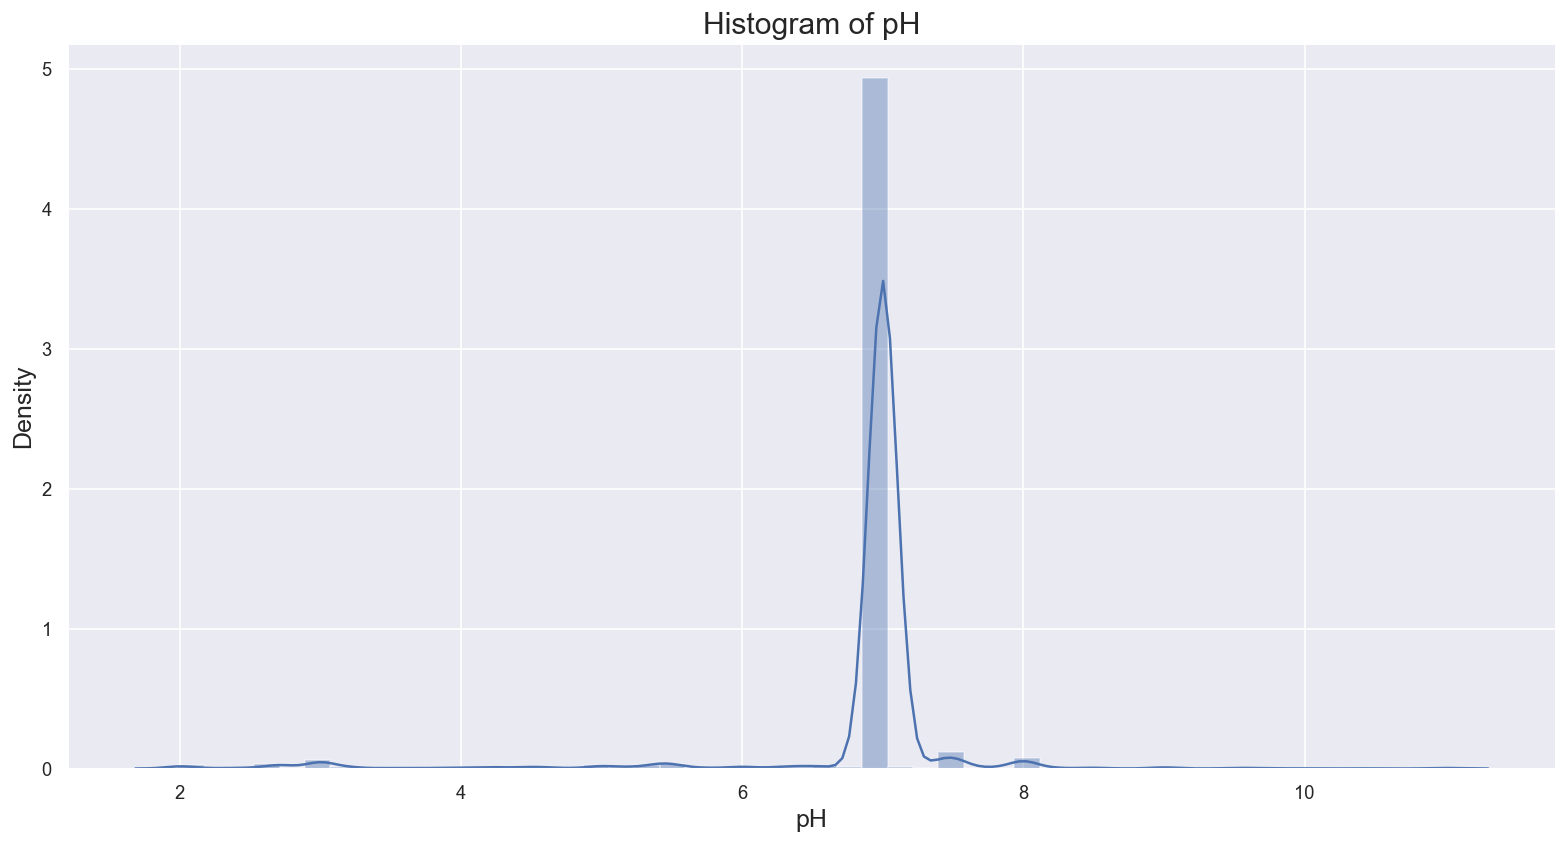

In [59]:
# graphically illstration via histogram
plt.figure(figsize=(16,8), dpi=120)
sns.set()
ax = sns.distplot(data_updated["pH"])
plt.title("Histogram of pH", fontsize=18)
plt.xlabel("pH", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.show()

In [61]:
data_updated["pH"] = data_updated["pH"].fillna(7.00)
data_updated["pH"].value_counts()

7.00    25795
7.50      419
8.00      377
3.00      250
7.40      189
        ...  
4.10        1
6.10        1
2.81        1
3.14        1
3.60        1
Name: pH, Length: 104, dtype: int64

In [62]:
# after that, no missing values
data_updated.isnull().sum()

seq_id              0
protein_sequence    0
pH                  0
data_source         0
tm                  0
dtype: int64

### 3.4 Abnormal values

from here basically focus on pH, because data_sourse is dummy value we defined, protein_sequence is complicate that we'll discuss later, and seq_id is merely an id

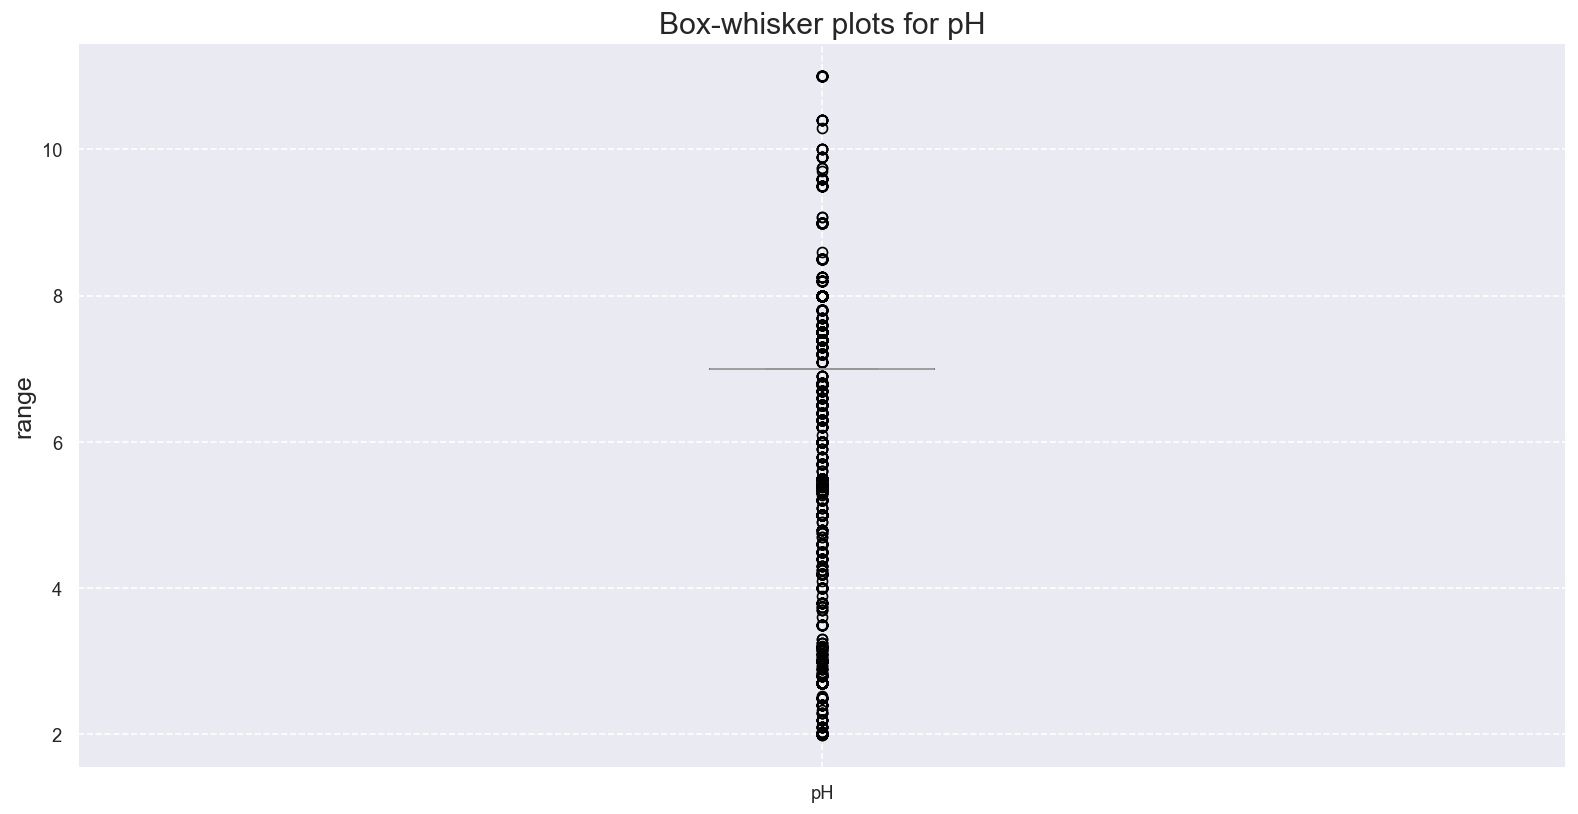

In [63]:
# looks as if pH is not neuture is abnormal, however, is stands in the experimental environment, so no more delete for pH
# or another thought is to drop pH != 7, which may also be an approach
plt.figure(figsize=(16,8), dpi=120)
data_updated.boxplot(column=["pH"])
plt.grid(linestyle="--")
plt.title("Box-whisker plots for pH", fontsize=18)
plt.ylabel("range", fontsize=15)
plt.show()

### 3.4 Dealing with protein_sequence

It's clearly that there're lots of features beneath hundreds of digits' protein sequence, there're two approaches for feature engineering: frequency for each amino acid, and their relative position etc.

#### 3.4.1 frequency for each amino acid

In [64]:
amino_acid = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] # there're only 20 different kinds of amino acids
for amino in amino_acid:
    data_updated[amino] = data_updated["protein_sequence"].str.count(amino)
    data_test[amino] = data_test["protein_sequence"].str.count(amino) # same goes for test dataset
data_updated.head()

,seq_id,protein_sequence,pH,data_source,tm,A,C,D,E,F,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,1,75.7,45,1,13,30,13,...,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,1,50.5,28,0,10,52,6,...,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,1,40.5,50,9,27,32,21,...,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,1,47.2,20,5,19,29,12,...,2,9,16,9,10,16,19,14,3,4
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1,49.5,86,14,78,78,32,...,31,65,128,54,63,148,120,124,16,47


#### 3.4.2 length for protein_sequence

In [65]:
for df in [data_updated, data_test]:
    df["length"] = df["protein_sequence"].apply(lambda x: len(x))

data_updated.head()

,seq_id,protein_sequence,pH,data_source,tm,A,C,D,E,F,...,N,P,Q,R,S,T,V,W,Y,length
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,1,75.7,45,1,13,30,13,...,5,18,6,25,11,14,37,4,3,341
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,1,50.5,28,0,10,52,6,...,6,8,22,30,14,12,13,3,3,286
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,1,40.5,50,9,27,32,21,...,15,20,25,31,33,30,30,3,16,497
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,1,47.2,20,5,19,29,12,...,9,16,9,10,16,19,14,3,4,265
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1,49.5,86,14,78,78,32,...,65,128,54,63,148,120,124,16,47,1451


#### 3.4.3 different kinds of amino acids

In [66]:
for df in [data_updated, data_test]:
    df["kinds"] = df["protein_sequence"].apply(lambda x: len(set(str(x))))

data_updated.head()

,seq_id,protein_sequence,pH,data_source,tm,A,C,D,E,F,...,P,Q,R,S,T,V,W,Y,length,kinds
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,1,75.7,45,1,13,30,13,...,18,6,25,11,14,37,4,3,341,20
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,1,50.5,28,0,10,52,6,...,8,22,30,14,12,13,3,3,286,19
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,1,40.5,50,9,27,32,21,...,20,25,31,33,30,30,3,16,497,20
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,1,47.2,20,5,19,29,12,...,16,9,10,16,19,14,3,4,265,20
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1,49.5,86,14,78,78,32,...,128,54,63,148,120,124,16,47,1451,20


#### 3.4.4 relative position for the amino acid

The relative position for amino acid also matters for proteins, as indicated in intro. From here we select most frequent amino acid combinations, from 2-combi to 3-combi, consider in higher situation features will be mostly 0, and the matrix will be too sparse, which is not good for fitting.

In [67]:
# collected by @Alexander_Shumilin, see https://www.kaggle.com/code/alexandershumilin/ideas-on-enzyme-prediction-features-as-char-comb/notebook

# 2 combination
col_2 = ['aa',
 'ae',
 'ag',
 'ai',
 'ak',
 'al',
 'as',
 'av',
 'da',
 'de',
 'dl',
 'ea',
 'ed',
 'ee',
 'eg',
 'ek',
 'el',
 'er',
 'es',
 'ev',
 'ga',
 'ge',
 'gg',
 'gk',
 'gl',
 'gs',
 'gv',
 'ia',
 'il',
 'ka',
 'ke',
 'kk',
 'kl',
 'ks',
 'la',
 'ld',
 'le',
 'lg',
 'li',
 'lk',
 'll',
 'ln',
 'lp',
 'lq',
 'lr',
 'ls',
 'lt',
 'lv',
 'pe',
 'pl',
 'ps',
 'ql',
 'rl',
 'sa',
 'se',
 'sg',
 'sk',
 'sl',
 'sp',
 'ss',
 'st',
 'sv',
 'ta',
 'tl',
 'ts',
 'va',
 've',
 'vl',
 'vs',
 'vv']
# 3 combination
col_3 = ['aaa',
 'aae',
 'aag',
 'aal',
 'aas',
 'aav',
 'aea',
 'aee',
 'ael',
 'agl',
 'ala',
 'ale',
 'alg',
 'alk',
 'all',
 'alr',
 'als',
 'asl',
 'ass',
 'ava',
 'avl',
 'dee',
 'dll',
 'eaa',
 'eae',
 'eal',
 'eea',
 'eee',
 'eek',
 'eel',
 'ekl',
 'ela',
 'ele',
 'elk',
 'ell',
 'erl',
 'esl',
 'evl',
 'ggg',
 'ggs',
 'gla',
 'gll',
 'gsg',
 'gss',
 'kal',
 'kel',
 'kkl',
 'kll',
 'laa',
 'lae',
 'lag',
 'lak',
 'lal',
 'las',
 'ldl',
 'lea',
 'lee',
 'lek',
 'lel',
 'lgl',
 'lka',
 'lke',
 'lkk',
 'lla',
 'lld',
 'lle',
 'llg',
 'llk',
 'lll',
 'llq',
 'llr',
 'lls',
 'llt',
 'llv',
 'lre',
 'lrl',
 'lsa',
 'lse',
 'lsg',
 'lsl',
 'lss',
 'lvl',
 'qll',
 'rll',
 'saa',
 'sal',
 'sas',
 'sgs',
 'sla',
 'sll',
 'sls',
 'ssa',
 'ssg',
 'ssl',
 'sss',
 'tll',
 'vaa',
 'vla',
 'vll']
# 4 combination
col_4 = ['aaaa',
 'aaal',
 'aaas',
 'aaav',
 'aaga',
 'aala',
 'aalg',
 'aall',
 'aavr',
 'aeal',
 'alaa',
 'alal',
 'alea',
 'alga',
 'alke',
 'alla',
 'alle',
 'alll',
 'asss',
 'avaa',
 'deee',
 'eaaa',
 'eaal',
 'eaav',
 'eaek',
 'eala',
 'eale',
 'ealk',
 'eall',
 'ealr',
 'eeal',
 'eeea',
 'eeed',
 'eeee',
 'eeek',
 'eeel',
 'eele',
 'eelk',
 'eell',
 'elae',
 'elar',
 'elee',
 'ella',
 'elle',
 'ellk',
 'erlr',
 'gggg',
 'gggs',
 'gsss',
 'klle',
 'laaa',
 'laal',
 'laek',
 'lael',
 'laks',
 'lala',
 'lall',
 'leaa',
 'leal',
 'leea',
 'leee',
 'leel',
 'lekl',
 'lell',
 'lkal',
 'lkel',
 'lkkl',
 'llaa',
 'llae',
 'llal',
 'llea',
 'llee',
 'llek',
 'llel',
 'llke',
 'llla',
 'llle',
 'llll',
 'lllv',
 'llsa',
 'llsl',
 'lltk',
 'lrlk',
 'lsal',
 'lsll',
 'lssl',
 'lsss',
 'lvll',
 'rlll',
 'saaa',
 'sall',
 'sass',
 'sgse',
 'sgss',
 'slss',
 'ssas',
 'ssgs',
 'ssls',
 'sssa',
 'sssg',
 'sssl',
 'ssss',
 'ssst',
 'vaaa',
 'vlls']

In [68]:
def relative_aa_counts(col, df):
    for aa_combi in col:
        df[aa_combi.upper()] = df["protein_sequence"].str.count(aa_combi.upper())
    return True

In [69]:
for df in [data_updated, data_test]:
    for col in [col_2, col_3]: # adding col_2, col_3
        relative_aa_counts(col, df)

In [70]:
data_updated.head()

,seq_id,protein_sequence,pH,data_source,tm,A,C,D,E,F,...,SLL,SLS,SSA,SSG,SSL,SSS,TLL,VAA,VLA,VLL
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,1,75.7,45,1,13,30,13,...,2,0,0,0,0,0,0,0,0,0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,1,50.5,28,0,10,52,6,...,0,0,0,0,0,0,0,0,0,1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,1,40.5,50,9,27,32,21,...,0,0,1,0,0,0,0,0,0,0
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,1,47.2,20,5,19,29,12,...,0,0,0,0,0,0,0,0,0,0
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1,49.5,86,14,78,78,32,...,0,1,1,1,2,3,0,1,0,1


#### 3.4.5  multicollinearity
drop variables that are highly related

In [71]:
def get_corr(df, threshold):
    tmp = df.copy()
    corr_matrix = tmp.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print("highly correlated variables to drop: " + str(to_drop))

    tmp.drop(to_drop, axis=1, inplace=True)
    print("after multicollinearity: " + str(tmp.shape))
    return tmp

In [72]:
# only check lines for amino acids
multi_index = amino_acid + [x.upper() for x in col_2] + [x.upper() for x in col_3]
selected_aa_combi = get_corr(data_updated[multi_index], 0.9)
selected_aa_combi

highly correlated variables to drop: ['K', 'T', 'V', 'LL', 'SS']
after multicollinearity: (28981, 184)


,A,C,D,E,F,G,H,I,L,M,...,SLL,SLS,SSA,SSG,SSL,SSS,TLL,VAA,VLA,VLL
0,45,1,13,30,13,38,3,14,37,8,...,2,0,0,0,0,0,0,0,0,0
1,28,0,10,52,6,18,4,13,23,2,...,0,0,0,0,0,0,0,0,0,1
2,50,9,27,32,21,65,11,16,18,6,...,0,0,1,0,0,0,0,0,0,0
3,20,5,19,29,12,16,7,10,28,2,...,0,0,0,0,0,0,0,0,0,0
4,86,14,78,78,32,84,40,71,104,31,...,0,1,1,1,2,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,33,12,38,31,18,51,15,21,46,13,...,0,0,0,0,0,0,0,0,0,0
31386,37,5,21,29,22,27,22,30,47,14,...,0,0,0,1,0,1,0,0,0,0
31387,13,1,7,7,7,11,2,6,6,7,...,0,0,0,0,0,0,0,0,0,0
31388,47,5,34,36,23,52,11,34,45,26,...,0,1,0,1,0,0,0,2,0,0


In [73]:
for df in [data_updated, data_test]:
    df.drop(columns=['K', 'T', 'V', 'LL', 'SS'], inplace=True)

In [74]:
data_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Columns: 191 entries, seq_id to VLL
dtypes: float64(2), int64(188), object(1)
memory usage: 42.5+ MB


#### 3.4.6 mutation

form here we want to catch the position where protain has a mutation, we catch three caterogies, the original and mutated amino aicd, and the position where such mutation happens. Consider base is the base of wildtype, which is more in line with with data_test. For train dataset we compare only the first amino acid in proteins which doesn't match the base as an approximation.

In [77]:
# inspired form https://www.kaggle.com/tianxiongyu/novozymes-enzyme-stability-prediction-09-12-2/edit
base = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"
    
def get_test_mutation(row):
    for i, (a,b) in enumerate(zip(row.protein_sequence, base)):
        if a != b: break
    row["wildtype"] = base[i]
    row["mutation"] = row.protein_sequence[i]
    row["position"] = i + 1
    return row

In [103]:
data_test_2 = data_test.copy()
data_updated_2 = data_updated.copy()

In [104]:
data_updated_2 = data_updated_2.apply(get_test_mutation, axis=1)
data_test_2 = data_test_2.apply(get_test_mutation, axis=1)

In [105]:
aa_dict = {"A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8, "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9,  "L": 3.8, "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5, "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3}

In [106]:
# substitute amino acid with its hydrophobicity index
data_updated_2["wildtype"] = data_updated_2.wildtype.map(aa_dict)
data_updated_2["mutation"] = data_updated_2.mutation.map(aa_dict)
data_test_2["wildtype"] =data_test_2.wildtype.map(aa_dict)
data_test_2["mutation"] =data_test_2.mutation.map(aa_dict)

In [107]:
data_updated_2.describe().apply(lambda x: round(x, 4))

,seq_id,pH,data_source,tm,A,C,D,E,F,G,...,SSG,SSL,SSS,TLL,VAA,VLA,VLL,wildtype,mutation,position
count,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,...,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000
mean,15733.5710,6.8737,0.9662,51.3600,34.4561,6.5997,25.0650,32.5655,16.9018,30.0613,...,0.2270,0.2843,0.3973,0.2155,0.2296,0.2158,0.2579,4.1522,1.5093,1.0104
std,9256.0531,0.7894,0.1808,12.0567,32.3014,10.1153,24.9734,35.6247,15.3332,27.1636,...,0.6293,0.6909,1.1104,0.5469,0.5440,0.5166,0.5890,0.5260,1.4637,0.1137
min,0.0000,1.9900,0.0000,25.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-3.5000,-4.5000,1.0000
25%,7511.0000,7.0000,1.0000,43.6000,15.0000,2.0000,11.0000,13.0000,7.0000,14.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.2000,1.9000,1.0000
50%,15575.0000,7.0000,1.0000,48.8000,27.0000,4.0000,19.0000,24.0000,13.0000,24.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.2000,1.9000,1.0000
75%,23896.0000,7.0000,1.0000,54.6000,44.0000,8.0000,31.0000,40.0000,22.0000,38.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.2000,1.9000,1.0000
max,31389.0000,11.0000,1.0000,130.0000,909.0000,363.0000,841.0000,995.0000,227.0000,577.0000,...,16.0000,17.0000,43.0000,13.0000,10.0000,7.0000,9.0000,4.2000,4.5000,4.0000


In [108]:
data_test_2.describe().apply(lambda x: round(x, 4))

,seq_id,pH,data_source,A,C,D,E,F,G,H,...,SSG,SSL,SSS,TLL,VAA,VLA,VLL,wildtype,mutation,position
count,2413.0000,2413.0,2413.0,2413.0000,2413.0000,2413.0000,2413.0000,2413.0000,2413.0000,2413.0000,...,2413.0000,2413.0000,2413.0000,2413.0,2413.0,2413.0000,2413.0000,2413.0000,2413.0000,2413.0000
mean,32596.0000,8.0,1.0,21.9494,4.0539,14.9884,7.0265,10.0186,18.9436,0.0489,...,0.0017,0.9863,0.0012,0.0,0.0,0.0017,0.0017,-0.9817,-0.3747,119.7232
std,696.7174,0.0,0.0,0.3776,0.2258,0.3191,0.2809,0.2994,0.3800,0.2157,...,0.0407,0.1197,0.0352,0.0,0.0,0.0407,0.0407,2.7167,2.8937,58.8190
min,31390.0000,8.0,1.0,21.0000,4.0000,14.0000,6.0000,9.0000,18.0000,0.0000,...,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,-4.5000,-4.5000,16.0000
25%,31993.0000,8.0,1.0,22.0000,4.0000,15.0000,7.0000,10.0000,19.0000,0.0000,...,0.0000,1.0000,0.0000,0.0,0.0,0.0000,0.0000,-3.5000,-3.5000,68.0000
50%,32596.0000,8.0,1.0,22.0000,4.0000,15.0000,7.0000,10.0000,19.0000,0.0000,...,0.0000,1.0000,0.0000,0.0,0.0,0.0000,0.0000,-0.9000,-0.8000,124.0000
75%,33199.0000,8.0,1.0,22.0000,4.0000,15.0000,7.0000,10.0000,19.0000,0.0000,...,0.0000,1.0000,0.0000,0.0,0.0,0.0000,0.0000,1.8000,2.5000,169.0000
max,33802.0000,8.0,1.0,23.0000,5.0000,16.0000,8.0000,11.0000,20.0000,1.0000,...,1.0000,2.0000,1.0000,0.0,0.0,1.0000,1.0000,4.5000,4.5000,221.0000


### 3.5 Export train and test dataset

In [109]:
# X
data_updated_2.to_csv("data_updated.csv", index = False)
data_updated

,seq_id,protein_sequence,pH,data_source,tm,A,C,D,E,F,...,SLL,SLS,SSA,SSG,SSL,SSS,TLL,VAA,VLA,VLL
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,1,75.7,45,1,13,30,13,...,2,0,0,0,0,0,0,0,0,0
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,1,50.5,28,0,10,52,6,...,0,0,0,0,0,0,0,0,0,1
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,1,40.5,50,9,27,32,21,...,0,0,1,0,0,0,0,0,0,0
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,1,47.2,20,5,19,29,12,...,0,0,0,0,0,0,0,0,0,0
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1,49.5,86,14,78,78,32,...,0,1,1,1,2,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,1,51.8,33,12,38,31,18,...,0,0,0,0,0,0,0,0,0,0
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,1,37.2,37,5,21,29,22,...,0,0,0,1,0,1,0,0,0,0
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,1,64.6,13,1,7,7,7,...,0,0,0,0,0,0,0,0,0,0
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,1,50.7,47,5,34,36,23,...,0,1,0,1,0,0,0,2,0,0


In [110]:
# y
data_test_2.to_csv("data_test.csv", index = False)
data_test

,seq_id,protein_sequence,pH,data_source,A,C,D,E,F,G,...,SLL,SLS,SSA,SSG,SSL,SSS,TLL,VAA,VLA,VLL
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,22,4,15,8,10,19,...,0,0,0,0,1,0,0,0,0,0
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,22,4,15,7,10,19,...,0,0,0,0,1,0,0,0,0,0
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,1,22,4,15,7,10,19,...,0,0,0,0,1,0,0,0,0,0
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,22,5,15,7,10,19,...,0,0,0,0,1,0,0,0,0,0
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,22,4,15,7,11,19,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,21,4,15,7,10,19,...,0,0,0,0,1,0,0,0,0,0
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,21,4,15,7,10,19,...,0,0,0,0,1,0,0,0,0,1
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,21,4,15,7,10,19,...,0,0,0,0,1,0,0,0,0,0
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,1,21,4,15,7,10,19,...,0,0,0,0,1,0,0,0,0,0


### 3.6 More features

After browsing lots of works, the score over 0.2 are basically using more features from external datasources.

It turns out for high scores on the leaderbord, they computational protein stability prediction based on **physics principles** such as BLOSUM, pLDDT, Differential pLDDT, DeepDDG, DeMaSk, RMSD, SASA, Rosetta , Thermonet and others. All of them work only with test dataset, detect some mutations and calculate sepcific metrics to get the stability ranking.  Actucally are not machine learning algorithm at all! But consider their high rankings, I'll briefly demonstrate one of their works in later chapters.

### 3.7 Statistical Analysis

In [112]:
data_updated_2[["pH", "length", "kinds", "tm", "position", "wildtype", "mutation"]].describe().apply(lambda x: round(x,4))

,pH,length,kinds,tm,position,wildtype,mutation
count,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000,28981.0000
mean,6.8737,450.4686,19.7070,51.3600,1.0104,4.1522,1.5093
std,0.7894,415.1590,0.7089,12.0567,0.1137,0.5260,1.4637
min,1.9900,5.0000,5.0000,25.1000,1.0000,-3.5000,-4.5000
25%,7.0000,212.0000,20.0000,43.6000,1.0000,4.2000,1.9000
50%,7.0000,351.0000,20.0000,48.8000,1.0000,4.2000,1.9000
75%,7.0000,537.0000,20.0000,54.6000,1.0000,4.2000,1.9000
max,11.0000,8798.0000,20.0000,130.0000,4.0000,4.2000,4.5000


<ipython-input-113-76ca0f30a09e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data_updated["tm"],  color=sns.desaturate("indianred", .8))


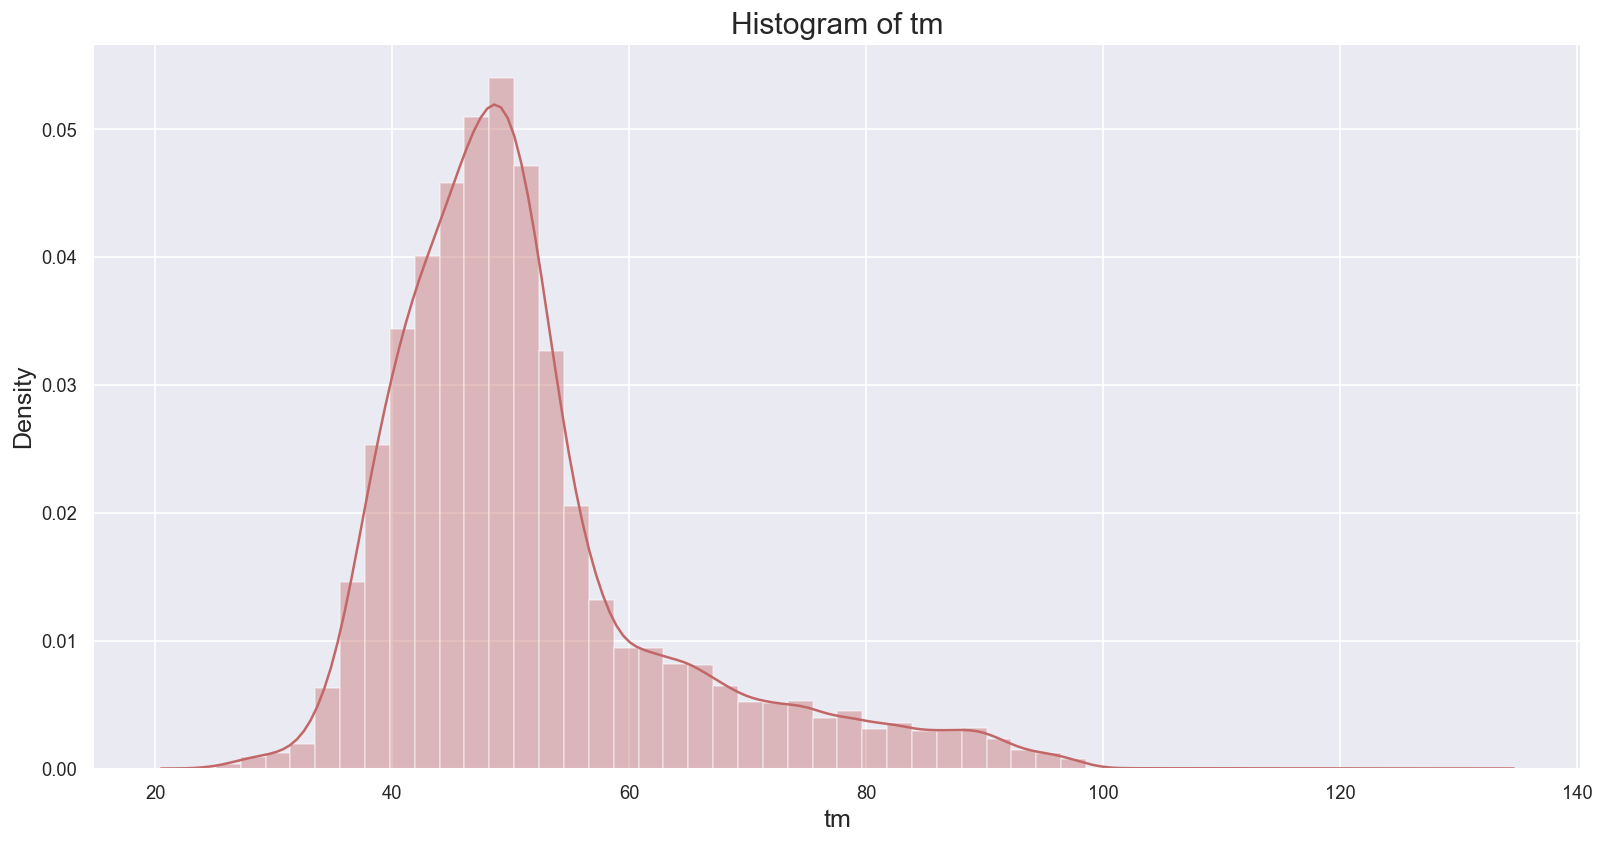

In [113]:
# check tm distribution
plt.figure(figsize=(16,8), dpi=120)
sns.set() 
ax = sns.distplot(data_updated["tm"],  color=sns.desaturate("indianred", .8))
plt.title("Histogram of tm", fontsize=18)
plt.xlabel("tm", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Relations between pH and tm')

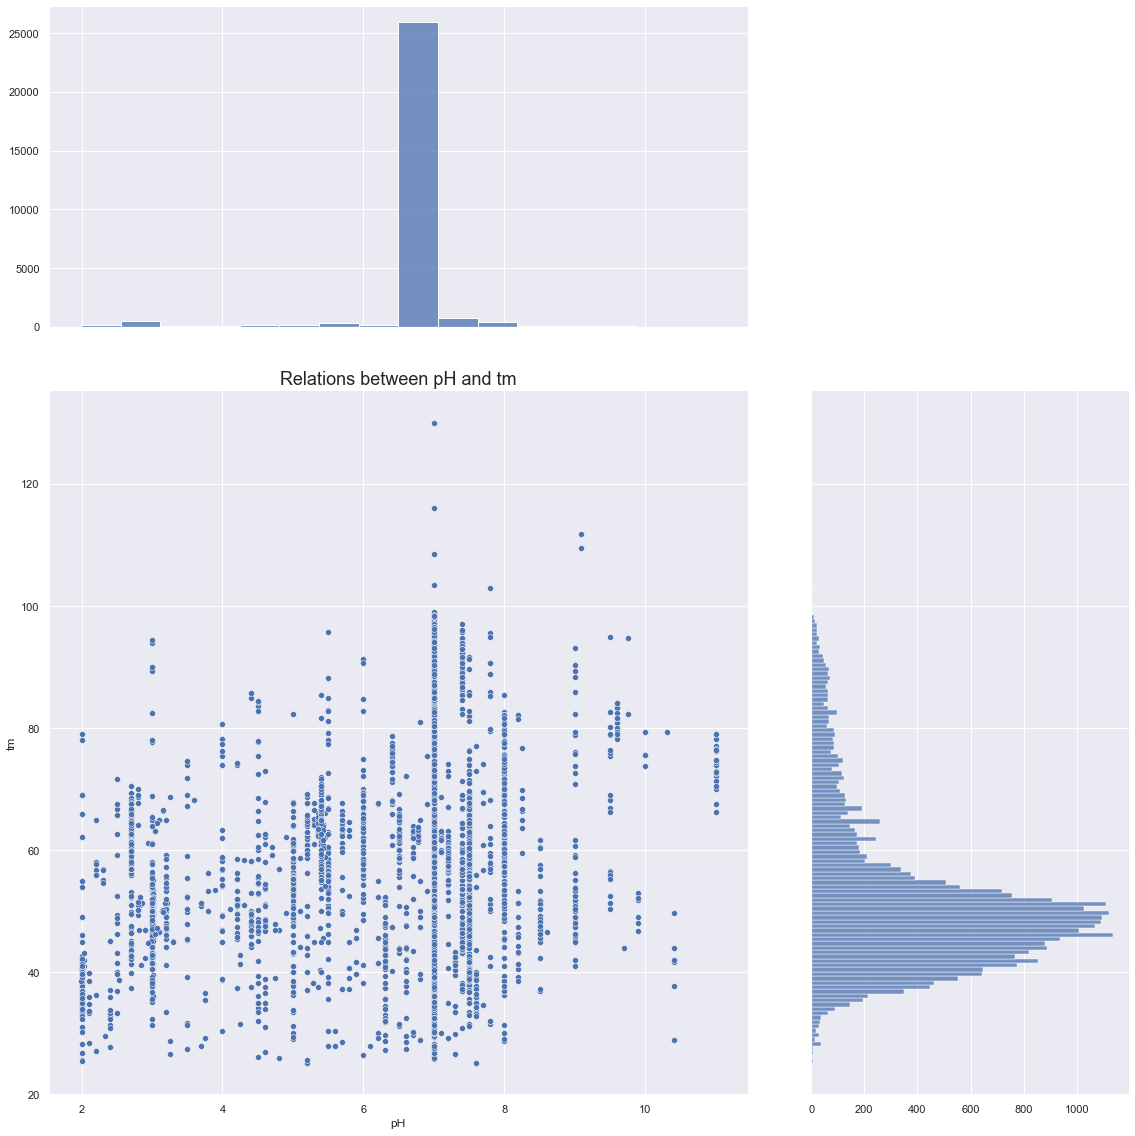

In [88]:
sns.jointplot(data=data_updated, x="pH", y="tm", height=16, ratio=2, marginal_ticks=True)
plt.title('Relations between pH and tm', fontsize=18)

Text(0.5, 1.0, 'Relations between length and tm')

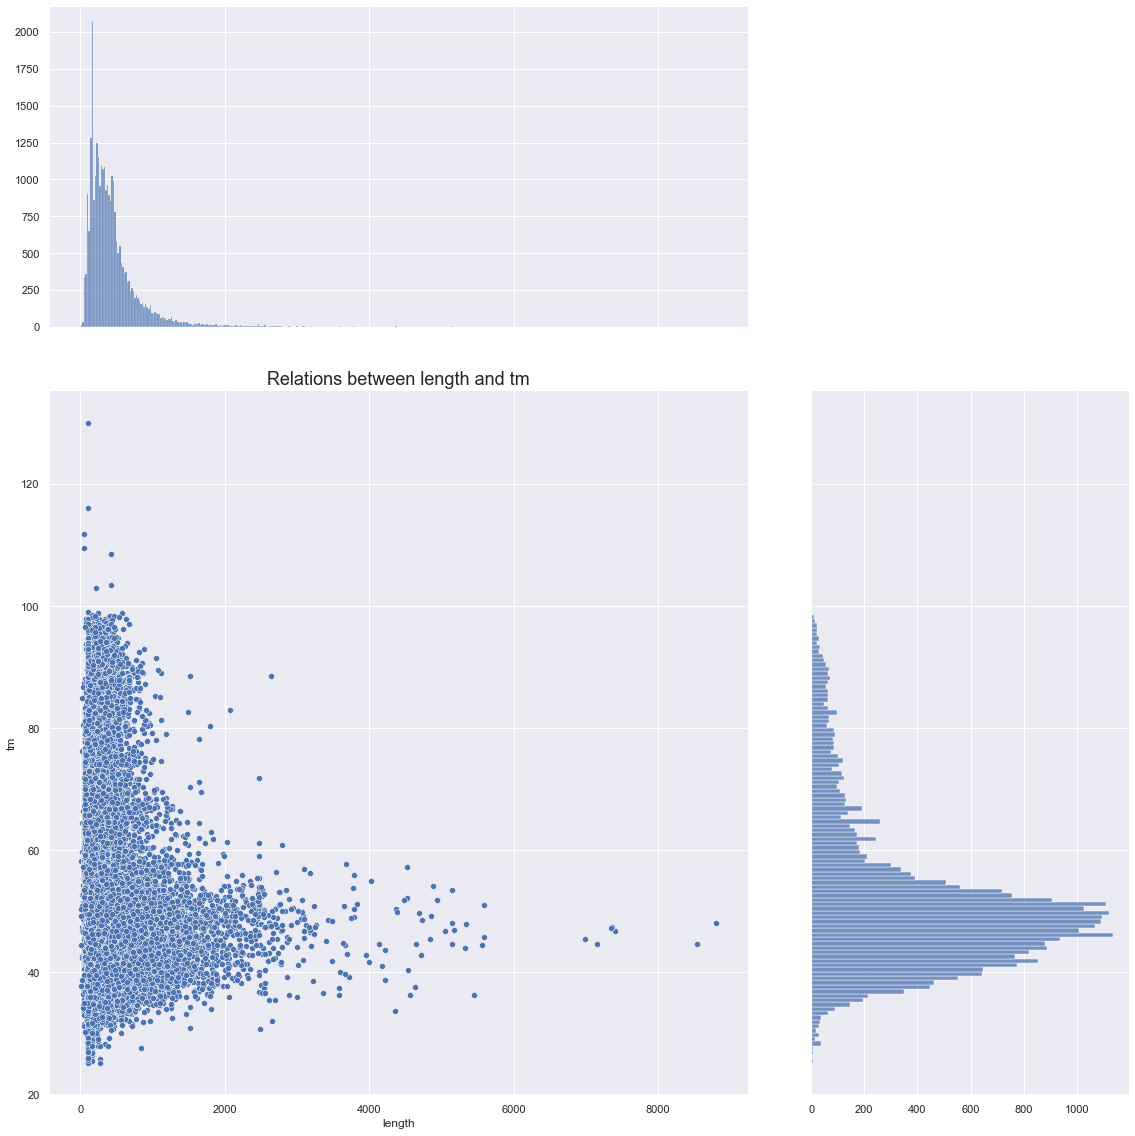

In [89]:
sns.jointplot(data=data_updated, x="length", y="tm", height=16, ratio=2, marginal_ticks=True)
plt.title('Relations between length and tm', fontsize=18)

Text(0.5, 1.0, 'Relations between numbers of different kinds of amino acids and tm')

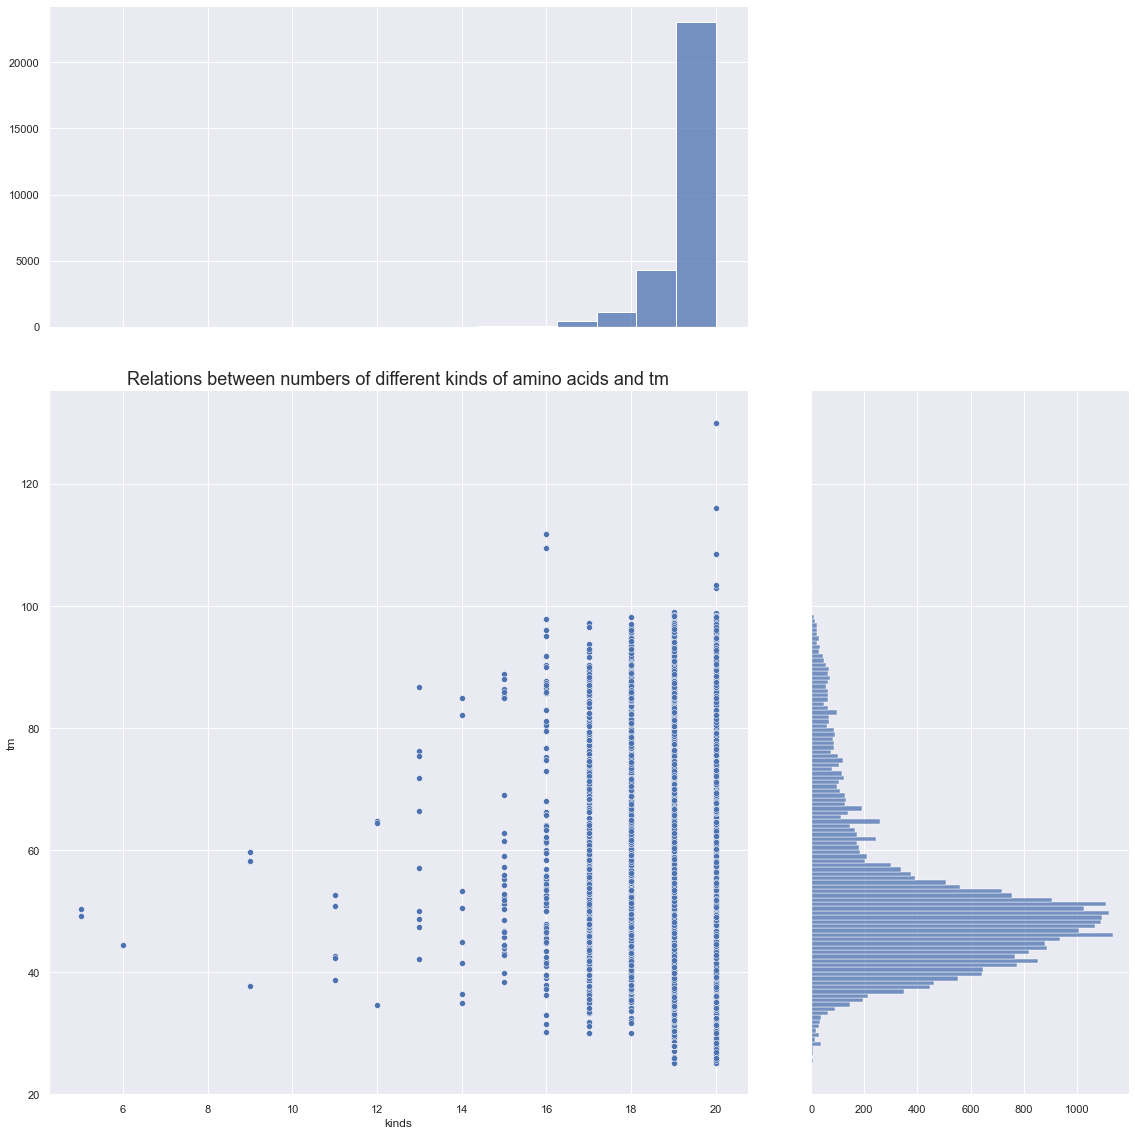

In [90]:
sns.jointplot(data=data_updated, x="kinds", y="tm", height=16, ratio=2, marginal_ticks=True)
plt.title('Relations between numbers of different kinds of amino acids and tm', fontsize=18)